# 1. Install necessary packages and import external libraries

In [ ]:
!pip install geemap        # --> Google Earth Engine (GEE)
!pip install geopandas      #--> Geospatial data 
%pip install scikit-learn   #--> Machine learning 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 KB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 28.

In [ ]:
# Talking with local terminal on your computer
import os

# GEE
import ee
import geemap
from geemap.conversion import js_snippet_to_py
from geemap import ml

# Geospatial data manipulation and analysis tools
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import seaborn as sns
from sklearn.datasets import (make_blobs,
                              make_circles,
                              make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

# Machine learning 
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
# Check which prorcessor unit we are using
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Initialize access to GEE
Map = geemap.Map()

# 0) Follow external link 
# 1) Choose project name
# 2) "Generate token"
# 3) Choose account
# 4) Give access (check of both boxes)
# 5) Copy authorization code
# 6) Add authorization code below

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=EEOKUK9W0JQxlFq2tD3wjZyJsHSmdZfNhM_iv3Xdhe0&tc=UoR8zECff4PSH3OZxQinlRkhMpAK9rPFzrkiYejAgwE&cc=T8nGjymuLZ5H1xZ4ZhSnOETlkK_XWw9QKhARqjgQYqk

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh5DW4F9lVELz3irjYyXu73GtYMbzKCIZ_NGnPYXtprWJSr9DvserSQ

Successfully saved authorization token.


In [ ]:
# Metadata on hardware, software etc. 
geemap.Report()

--------------------------------------------------------------------------------
  Date: Thu Feb 16 06:49:28 2023 UTC

                OS : Linux
            CPU(s) : 2
           Machine : x86_64
      Architecture : 64bit
               RAM : 12.7 GiB
       Environment : IPython

  Python 3.8.10 (default, Nov 14 2022, 12:59:47)  [GCC 9.4.0]

            geemap : 0.19.6
                ee : 0.1.340
        ipyleaflet : 0.17.2
            folium : 0.12.1.post1
        jupyterlab : Module not found
          notebook : 5.7.16
         ipyevents : 2.0.1
         geopandas : 0.12.2
--------------------------------------------------------------------------------

In [ ]:
# Make a cloud-free Sentinel-2 composite (from raw imagery).
# Source code: https://developers.google.com/earth-engine/guides/ic_info. Accessed: 16.02.2023

point = ee.Geometry.Point([-69.740859, 43.544235]) # Center around a specified point

image = (
    ee.ImageCollection('COPERNICUS/S2_SR')         # Dataset from GEE
    .filterBounds(point)                           # Filter satellite-images around our region of interest (ROI)
    .filterDate('2019-06-02','2019-10-01')         # Filter time
    .sort('CLOUDY_PIXEL_PERCENTAGE')               # fiter for cloud percentage
    .first()                                       # Take the image with least cloud coverage
    .select('B[2-4]','B[8]')                       # Select bands B2, B3, B4, and B8 as features
)

print('Date image was taken in the format YYYY-MM-DD:', ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()) # Show the image-date
print('Cloud percentage: ', image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())

Date image was taken in the format YYYY-MM-DD: 2019-07-19
Cloud percentage:  0.03149


## Sun-glint correction

- Adaptation from https://www.youtube.com/watch?v=_V0X1LdSta4. Accessed 10.02.2023.
- The python dicitonary needs ** in front of the dictionary in order pass keyword arguments into it. This does not go automatically with the 'js_snippet_to_py'. See https://realpython.com/python-kwargs-and-args/ for complete explenation. Accessed 16.02.2023. 

In [ ]:
Map.set_center(-69.740859, 43.544235, zoom=9)

# Show sentinel-2 tile in map
vis_params = {"bands": [ 'B2', 'B3', 'B4'], "min": 0, "max": 1500, "gamma": 1.5}
Map.addLayer(image, vis_params, 'Sentinel-2 images')

Map 
# Use toolbar on the left side, e.g., " Draw a rectangle" over a sight 
# to extract NIR values (min and random) from two pixels. 
# Areas of deep waters are recommended.

Map(center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [ ]:
Map.draw_features                                # Collects the drawn rectangle(s)
glint = ee.FeatureCollection(Map.draw_features)  # Stores the rectangle(s) geometry to extract NIR-values from

def deglint(img):
  '''
  Sun-glint correction of image
  '''
  # Blue (B2) and NIR (B8) 
  # linearfitB gets linear relationship (slope) and offset between the Blue and NIR bands
  linearfitB = img.select(['B8','B2']).reduceRegion(
    **{
    'reducer': ee.Reducer.linearFit(),  
    'geometry': glint,
    'scale':10,
    'maxPixels':1e9
    }) 

  # Green (B3) and NIR (B8)
  # linearfitG gets linear relationship (slope) and offset between the Green and NIR bands  
  linearfitG = img.select(['B8','B3']).reduceRegion(
     **{
      'reducer': ee.Reducer.linearFit(),
      'geometry': glint,
      'scale':10,
      'maxPixels':1e9
      })  
  # Red and NIR
  # linearfitR gets linear relationship (slope) and offset between the Red and NIR bands
  linearfitR = img.select(['B8','B4']).reduceRegion(
    **{
      'reducer': ee.Reducer.linearFit(),
      'geometry': glint,
      'scale':10,
      'maxPixels':1e9
      })
  
  
  slopeImage = ee.Dictionary(            # Collects the slopes in a dictionary 
  {
      'Blue': linearfitB.get('scale'),
      'Green': linearfitG.get('scale'),
      'Red': linearfitR.get('scale')
      }).toImage()                        # Converts dicitonary to image
      
  # Define minimum NIR value
  minNIR = img.select('B8').reduceRegion(ee.Reducer.min(), glint).toImage()

  # Deglint formula
  return img.select(['B2','B3', 'B4']).subtract(slopeImage.multiply(img.select('B8').subtract(minNIR)))

# Apply deglint function
S2_deglint = deglint(image) 

# Print bandnames of deglinted senitnel-2 image
S2_deglint.bandNames() 

# Might get a HttpError here stating: 
# "Too many pixels in the region. Found 11099489, but maxPixels allows only 10000000."
# The problem is that the rectangle created to extract NIR-values is too big. 
# Thus, create a new and smaller rectangle, or for future recommendations,
# create a error-statement (using if-else) to where this is clearly explained or something similar. 


In [ ]:
# Show deglinted image in map
vis_params_deglint = {"bands": [ 'B2', 'B3','B4'], "min": 0, "max": 1500, 'gamma':1.5}

Map.addLayer(S2_deglint, vis_params_deglint, 'sun-glint corrected Sent-2')
Map

Map(bottom=48190.0, center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Calculating NDVI
nir = image.select('B8')
red = image.select('B4')
ndvi_image = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

# Add NIR to deglinted image
S2_deglint = S2_deglint.addBands(nir)

# Add NDVI to RGB-image and deglinted image
S2_deglint = S2_deglint.addBands(ndvi_image)
image = image.addBands(ndvi_image)

S2_deglint.bandNames()
# sent2019 = ee.Image('COPERNICUS/S2/20190719T153601_20190719T153707_T19TDJ')

# Add bathemerty band to image

In [ ]:
Map # Draw region of interest

Map(bottom=48190.0, center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Store geometry of region of interest in 'roi'
roi = ee.FeatureCollection(Map.draw_last_feature)

Map.addLayer(roi, {}, "Region of interest")
Map

Map(bottom=48190.0, center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
#Citations:
# Amante, C. and B. W. Eakins, ETOPO1 1 Arc-Minute Global Relief Model: Procedures, Data Sources and Analysis. 
# NOAA Technical Memorandum NESDIS NGDC-24, 19 pp, March 2009.

# Import elevation dataset from GEE
dataset = ee.Image('NOAA/NGDC/ETOPO1')
bathymetry_clipped = dataset.clip(roi)

# Extract band 'bedrock' and rename it bathymetry for convenience
bathymetry = bathymetry_clipped.select('bedrock').rename('bathymetry')

# Set visualization parameters
bathymetryVis = {
  'min': -7000.0,
  'max': 3000.0,
  'palette': ['011de2', 'afafaf', '3603ff', 'fff477', 'b42109'],
}

S2_deglint = S2_deglint.addBands(bathymetry)
image = image.addBands(bathymetry)

Map.addLayer(bathymetry, bathymetryVis, 'bathymetry')
Map

Map(bottom=48190.0, center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Add NDVI-image to map
ndviParams = {min: -1, max: 1, 'palette': ['blue', 'white', 'green']}
Map.addLayer(ndvi_image, ndviParams, 'NDVI image')
Map

Map(bottom=48190.0, center=[43.544235, -69.740859], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# image.bandNames()
S2_deglint.bandNames()

# Pixel-based classification
- 1) Import geometries to fetch samples from
- 2) Sample data
- 3) Locally store data for faster processing for next time as well as reproducability



### Import geometries to fetch samples from

In [ ]:
# Add ground truth data geometry of seagrass and seaweed
# Must upload to google colabs for each new runtime...
shp_path_SW = '/content/try1.shp'
seaweed_shp = geemap.shp_to_ee(shp_path_SW)

shp_path_SG = '/content/MaineDEP_-_Eelgrass_2018_(Casco_Bay_Only).shp'
seagrass_shp = geemap.shp_to_ee(shp_path_SG)

shp_path_water = '/content/water.shp'
water_shp = geemap.shp_to_ee(shp_path_water)


### Sample data

In [ ]:
# Use functions below if data to get sample data fro training, validaiton and test. 
# To save time, these sets have already been created and stored locally.
# The files used her ecan be found with the rest on git-hub for reproducable results.

'''
# Samples of seaweed
sample_sw = S2_deglint.sample(**{
  'region': seaweed_shp,
  'numPixels':25000, # As it does not collect clsoe to 5000 samples when set to this, we increase this value. Should be adjusted if error is thrown.
  'geometries': True,
  'seed' :3,
  'scale': 10,      # Set to 10 as our resolution is 10-meters    
})

# Samples of seagrass
sample_sg = S2_deglint.sample(**{
  'region': seagrass_shp,
  'numPixels':5000,  # 5000 pixels is the maximum number of pixels that can be processed in GEE
  'geometries': True,
  'seed' :3,
  'scale': 10,
})

# Sample of water
sample_water = S2_deglint.sample(**{
  'region': water_shp,
  'numPixels':5000,
  'geometries': True,
  'seed' :3,
  'scale': 10,
})


Code to display sample-points if needed
Map.addLayer(sample_sg, vis_params_sg, 'seagrass samples')
Map.addLayer(sample_sw, vis_params_sw, 'seaweed samples')
Map.addLayer(sample_water, vis_params_water, 'water samples')

Map

# Convert samples from ee-objects to geodataframes
gdf_sw = geemap.ee_to_geopandas(sample_sw)
gdf_sg = geemap.ee_to_geopandas(sample_sg)
gdf_water = geemap.ee_to_geopandas(sample_water)


# Get number of samples fetched for each class
length_sg = len(gdf_sg)
length_sw = len(gdf_sw)
length_water = len(gdf_water)
print(f'We have: \n {length_sg} samples from the seagrass polygons \n {length_sw} samples from the seaweed polygons \n {length_water} samples from the water polygons ')

 # Crete Class column 'Cover'
gdf_water['Cover'] =  int(1) # class water
gdf_sw['Cover'] =  int(2)    # class seaweed
gdf_sg['Cover'] =  int(3)    # class seagrass


# Merge the three dataframes and create a single dataset
# Source code: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html. Accessed 08.02.23
frames = [gdf_water, gdf_sw, gdf_sg]

data = pd.concat(frames, ignore_index=True)
print(len(data))
'''

In [ ]:
'''
# Test-code to increase sample size of seaweed as too few samples where fetched 
# when 'numPixels' = 5000. First tune just 'numPixels'. If not working,
# 'seeds' can also be tuned.
 
sample_sw = S2_deglint.sample(**{
  'region': seaweed_shp,
  'numPixels':25000,
  'geometries': True,
  'seed' :3,
  'scale': 10,
})

print(f'We have:{sample_sw.size().getInfo()} samples from the seaweed polygons ')
'''

### Locally store data for faster processing for next time as well as reproducability

In [ ]:
# How to locally store sample data:

# All data: 
# 1) data = data.drop('geometry', axis=1)
# 2) data.to_csv(r'/content/data_pixel_based_UML_23.csv', index=False)'

# Only training data:
# 1) data = data.sample(frac=1)
# 2) train = data.drop(['geometry','Cover'], axis=1)
# 3) train.to_csv(r'/content/train_pixel_based_UML_23.csv', index=False)

# Only class data:
# 1) y_true = data['Cover']
# 2) y_true.to_csv(r'/content/ytrue_pixel_based_UML_23.csv', index=False)

# Access locally stored data: 
# 1) Upload files to session storage
# 2) Choose training and classs data seperatly:
df = pd.read_csv('/content/train_pixel_based_UML_23.csv')
y_true_df = pd.read_csv('/content/ytrue_pixel_based_UML_23.csv')
data = pd.read_csv('/content/data_pixel_based_UML_23.csv')

df.columns
#data.isnull().sum().sum() # Check null-values, in which case must be removed.

Index(['B2', 'B3', 'B4', 'B8', 'NDVI', 'bathymetry'], dtype='object')

# Unsupervised 
- 1) K-means 
- 2) Confusion matrix
- 3) Compute accuray of K-means
- 4) land mask

### K-means on training data
- Source code: https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a. Accessed 15.02.23


In [ ]:
# Makes the plots function and look nicer in the notebook
%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

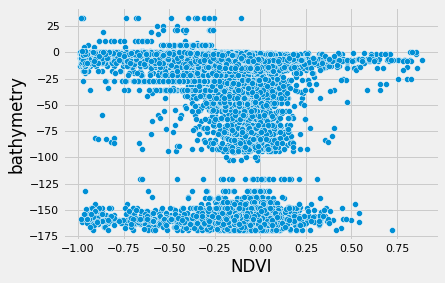

In [ ]:
# Use seaborn to plot the training data. NDVI and bathymetry against each other. 
sns.scatterplot(data=df, x="NDVI", y="bathymetry") 

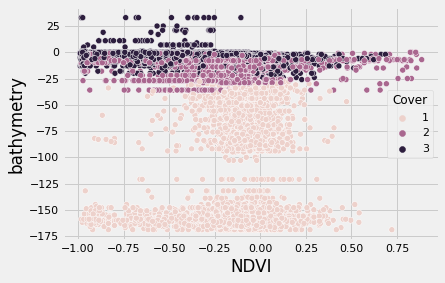

In [ ]:
# Plot the data so to visuaize the 3 true clusters  TRUE VALUES
# This is what we want to see after using k-means
sns.scatterplot(data=data, x="NDVI", y="bathymetry", hue="Cover")

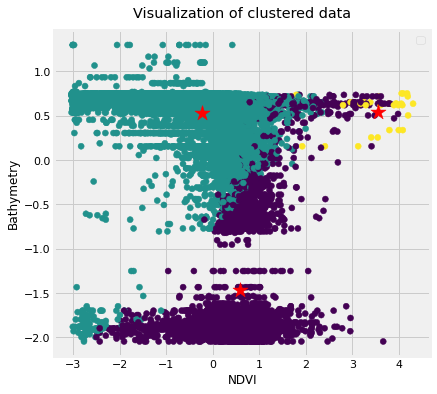

In [ ]:
# Standardize the data
X_std = StandardScaler().fit_transform(df)

# Run local implementation of kmeans
km = KMeans(n_clusters=3, max_iter=100, random_state=40)
km.fit(X_std)
centroids = km.cluster_centers_ # Get centroid of each cluster to display later
y_pred = km.fit_predict(X_std)  # Store predicted class for each point

# Scatter plot of data colored with labels
fig, ax2 = plt.subplots(figsize=(6, 6))
ax2.scatter(X_std[:, 4], X_std[:, 5], c=y_pred)
ax2.scatter(centroids[:, 4], centroids[:, 5], marker='*', c='r', s=250)
ax2.set_xlabel('NDVI')
ax2.set_ylabel('Bathymetry')
ax2.set_title('Visualization of clustered data', y=1.02)
ax2.legend((X_std[:, 4], X_std[:, 5], centroids), ('s', 'label2', 'label3'))  CLASSIFIED PIXEL BASED - THEN I DO THE SAME WITH OBJECT BASED. fOLLOW SAME METHOD JUST WITH BIGGER PIXELS .A.K.A SUPER-PIXELS

BUT, KMEANS WORK BAD. cONSIDERING USING A DENSITY CLUSTERING ALGORITHM INSTEAD. AND PCA. 

In [ ]:
# Chech label of classes and count how many instances there are of each predicted by k-means
labels, counts = np.unique(y_pred, return_counts=True)
print(labels)  # [0 1 2]
#              [10948  3910    30]
print(counts)

[0 1 2]
[ 3937 10921    30]


In [ ]:
# Chech labels and count of each true classes 
labels, counts = np.unique(y_true_df, return_counts=True)
print(labels)
print(counts)


[1 2 3]
[5000 4947 4941]


In [ ]:
# As the lables are just named differently, 
# we change them so they allign with the predicted values
y_corr_true = y_true_df.replace([1,2,3],[0,1,2])

In [ ]:
# Must convert dataframe to numpy array to create confusion matrix
y_true_np= y_corr_true.to_numpy()
labels, counts = np.unique(y_true_np, return_counts=True)
print(labels)
print(counts)

[0 1 2]
[5000 4947 4941]


In [ ]:
cm = confusion_matrix(y_true_np, y_pred, labels=labels)
cm

array([[3710, 1290,    0],
       [ 154, 4763,   30],
       [  73, 4868,    0]])

In [ ]:
# Rename numeric class labels to names for intepretation
classes = np.array(['water','seaweed','seagrass'])
print(classes)
type(classes)

class_dict = dict(zip(classes,range(len(classes))))

class_dict

['water' 'seaweed' 'seagrass']


{'water': 0, 'seaweed': 1, 'seagrass': 2}

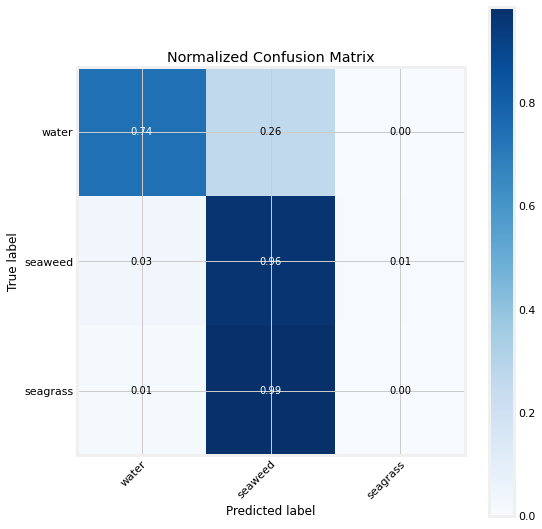

In [ ]:
# plot the confusion matrix
%matplotlib inline 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Because we have a single column. We are summing across a column --> We get out an arrray 
fig, ax = plt.subplots(figsize=(8, 8))  # create firgure 
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # cmap = colormap
ax.figure.colorbar(im, ax=ax)

## Format confusion matrix.
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true_np, y_pred)

0.5691160666308437

In [ ]:
vis_params_sw = {'color':'#7b3e00'}
vis_params_sg = {'color':'1c5f2c'}   

#Map.addLayer(sample_sg, vis_params_sg, 'seagrass samples')
#Map.addLayer(sample_sw, vis_params_sw, 'seaweed samples')
#Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass')
#Map.addLayer(seaweed_shp, vis_params_sw, 'seaweed')
#Map


### Import land mask

In [ ]:
js_snippet = """

// Load or import the Hansen et al. forest change dataset.
var hansenImage = ee.Image('UMD/hansen/global_forest_change_2015');

// Select the land/water mask.
var datamask = hansenImage.select('datamask');

// Create a binary mask.
var mask = datamask.eq(2);

// Update the composite mask with the water mask.
var maskedComposite = median.updateMask(mask);
Map.addLayer(maskedComposite, visParams, 'masked');

"""
lines = geemap.js_snippet_to_py(js_snippet, add_new_cell=False, import_ee=False, import_geemap=False, show_map=False)
for line in lines:
    print(line.rstrip())


# Load or import the Hansen et al. forest change dataset.
hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')

# Select the land/water mask.
datamask = hansenImage.select('datamask')

# Create a binary mask.
mask = datamask.eq(2)

# Update the composite mask with the water mask.
maskedComposite = median.updateMask(mask)
Map.addLayer(maskedComposite, visParams, 'masked')


In [ ]:
'''
# Method to create a water class based on low NDVI-values.

def create_classlabels(geodataframe):
  #takes only a geodataframe containing NDVI-values in it and more than 2 features. 
  user_input = input("Enter 'seaweed' or 'seagrass': ")

  # Distinguishing between seagrass and seaweed data 
  if user_input.lower() == 'seaweed':
    class1 = int(1)
  elif user_input.lower() == 'seagrass':
    class1 = int(2)
  else: 
    print("You can only insert 'seaweed' or 'seagrass' , please try again.")
 
 # Crete Class column 'Cover'
  geodataframe['Cover'] =  " "
  class0 = int(0) # water

  # Assign data to classes depending on the ndvi-value
  for index in range(len(geodataframe)):
    ndvi = geodataframe['NDVI'][index]
    if ndvi < -0.8:
      geodataframe.at[index,'Cover'] = class0 # water
    else:
      geodataframe.at[index,'Cover'] = class1 # seaweed or seagrass

  return geodataframe.head(3)

create_classlabels(gdf_sg)
create_classlabels(gdf_sw)


data = gdf_sw.append(gdf_sg, ignore_index=True)
data.head()
data.aggregate(['min', 'max'])'
len(data)
df=joint_df.dropna()
len(df)
#df.isnull().sum().sum()
df.head()

water = df_count['NDVI'][0]   # water = 0
seaweed = df_count['NDVI'][1] # seaweed = 1 
seagrass = df_count['NDVI'][2] # seagrass = 2

print(f'We have: \n {water} datapoints of water \n {seagrass} datapoints of seagrass \n {seaweed} datapoints of seaweed')
print('\n'
  + str(80) + '% for training \n'
  + str(10) + '% for validation \n'
  + str(10) + '% for test \n'
  'of the total dataset' 
)
# Randomize the data
df = df.sample(frac=1).reset_index(drop=True)
df.head()
'''

# Supervised 
- 1) Create training, validation and test data
- 2) Random Forest 
- 3) Visualisation of parameters RF
- 4) Parameter tuning of RF (grid search and CV)


In [ ]:
data.columns

Index(['B2', 'B3', 'B4', 'B8', 'NDVI', 'bathymetry', 'Cover'], dtype='object')

In [ ]:
# get the features and labels into separate variables
label = 'Cover'
feature_names = ['B2', 'B3', 'B4', 'B8', 'NDVI', 'bathymetry']
X = data[feature_names]  

#Standardize the data for improved results as the feauters have different units
# as this can cause bias
X_std = StandardScaler().fit_transform(X)
y = data[label]
y=y.astype('int')  # y was firstly of type 'object', needs to be an integer for sklearn to recognize it.

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X_std, y, train_size=0.8, random_state=42)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42, shuffle=True)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

# Parameter tuning of RF

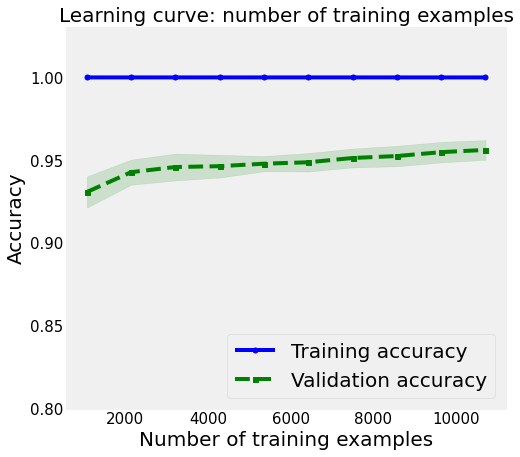

In [ ]:
# Parameter tuning visualization
# Create an instance of a RF classifier and use default parameters
# Source code: 
'''
@book{Sebast19,
author = {Sebastian Raschka and Vahid Mirjalili},
year = {2019},
month = {12},
title = {Python Machine Learning
Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2}
}
'''

rfc=RandomForestClassifier(random_state=42)
train_sizes, train_scores, test_scores = learning_curve(estimator = rfc,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                        cv=10,
                                                        n_jobs=1)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)
  
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--', marker='s',
         markersize=5, label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples', fontsize = 20)
plt.ylabel('Accuracy',fontsize = 20 )
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='lower right', prop={'size': 20})
plt.ylim([0.8,1.03])
plt.title('Learning curve: number of training examples', fontsize = 20)

plt.show()


# Parameter tuning: Grid search 
- 1) Initiate range of values for the grid search to go through
- 2) Grid search with CV

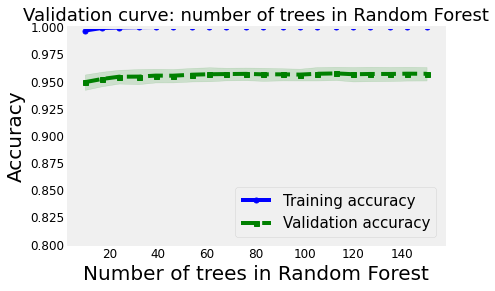

In [ ]:
#Number of trees in RF
n_estimators = [int(x) for x in np.linspace(start=10, stop = 150, num = 20)]

# Number of feature sto consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth=[2,4,10]

#Minimum samples required to split a node
min_samples_split = [2,5]

# Minimum number of samples required at each leaf node 
min_samples_leaf = [1,2]
#Method of selecting samples for training the tree
bootstrap = [True, False]

train_scores, test_scores = validation_curve(estimator = rfc,
                                           X=X_train,
                                           y=y_train,
                                           param_name='n_estimators',
                                           param_range=n_estimators,
                                           cv=10)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(n_estimators, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(n_estimators,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(n_estimators, test_mean,
         color='green', linestyle='--', marker='s',
         markersize=5, label='Validation accuracy')

plt.fill_between(n_estimators,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of trees in Random Forest',  fontsize = 20)
plt.ylabel('Accuracy',  fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc='lower right', prop={'size': 15})
plt.ylim([0.8,1.0])
plt.title('Validation curve: number of trees in Random Forest', fontsize = 18)
plt.show()



In [ ]:
# See from the above graph that we can reduce the search-space of n_estimators 
n_estimators = [int(x) for x in np.linspace(start=10, stop = 30, num = 5)]

In [ ]:
# Create parameter grid
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth' : max_depth,
    'min_samples_split' :min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap':bootstrap
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_score_)
print(CV_rfc.best_params_)

0.9566750629722922
{'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


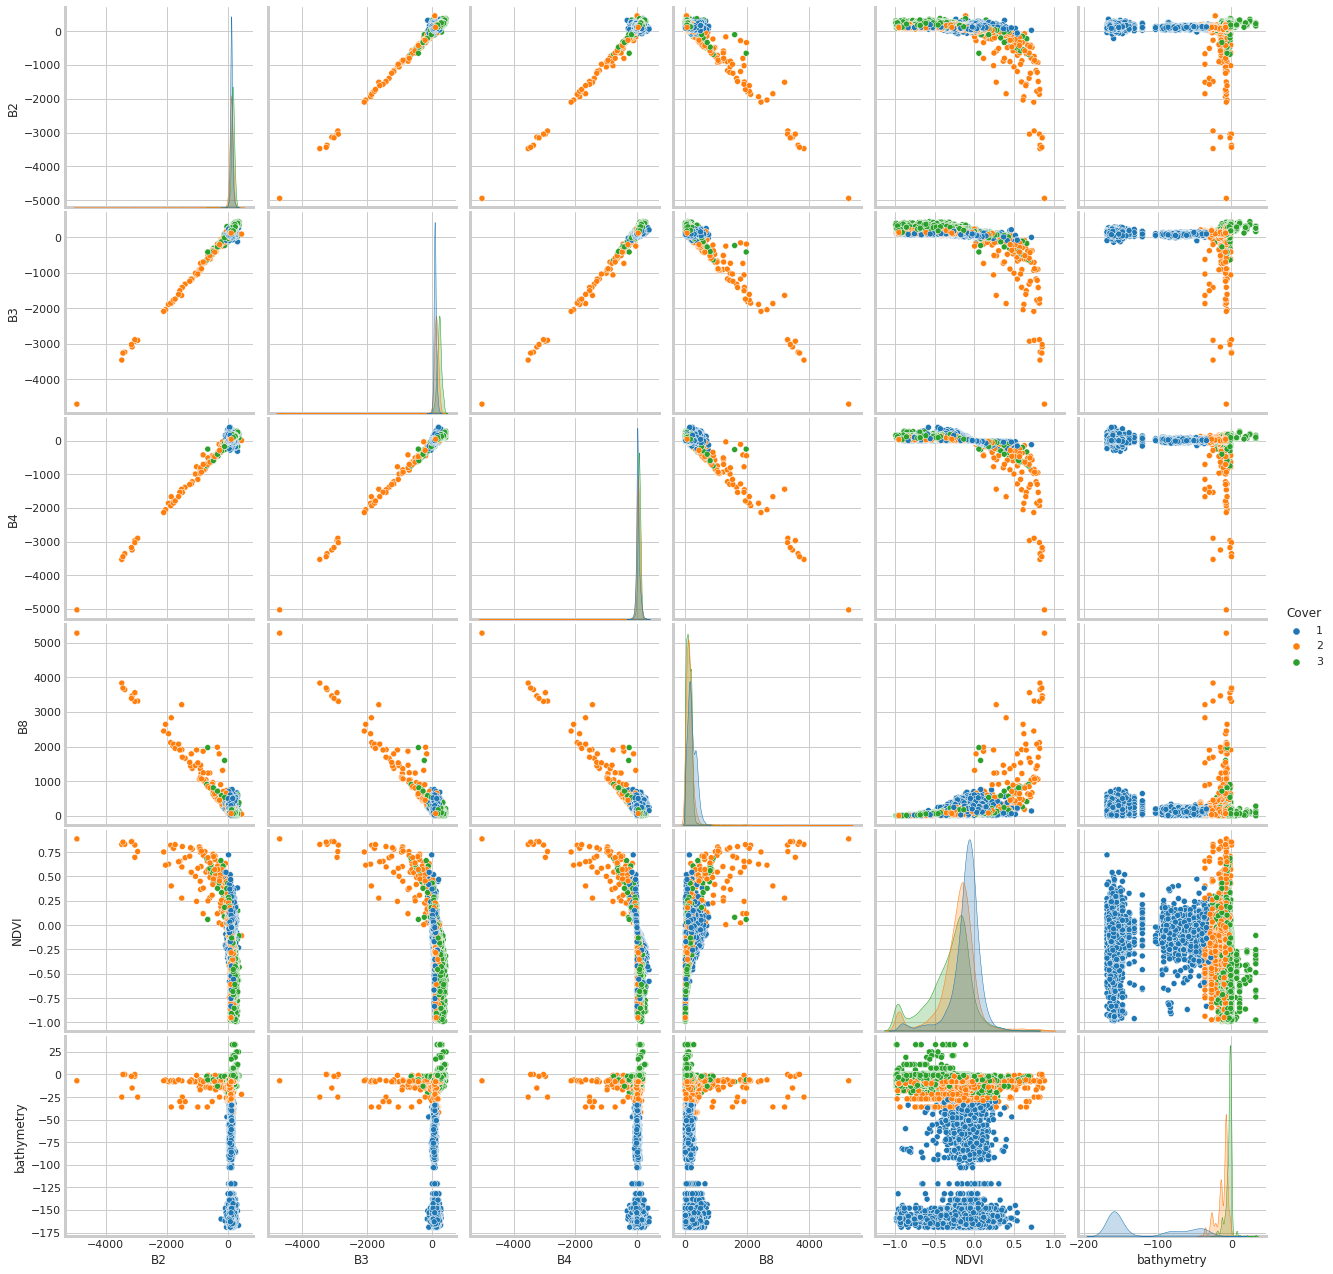

In [ ]:
sns.set_style("whitegrid");
#sns.pairplot(df, hue="Cover", size=3);
sns.pairplot(data, hue="Cover", palette="tab10",height=2.5, size=3)
plt.show()

In [ ]:
data = pd.read_csv('/content/data_pixel_based_UML_23.csv')
len(data)

14888

In [ ]:
data['Cover'].unique()

array([3, 1, 2])

In [ ]:
 data['Cover'].replace([1,2,3], [0,1,2], inplace=True)

In [ ]:
data.head()

,B2,B3,B4,B8,NDVI,bathymetry,Cover
0,258.735615,330.800132,131.161099,57,-0.534694,-6,2
1,147.000000,143.000000,49.000000,1,-0.960000,-20,2
2,210.338204,295.007563,82.333493,179,-0.190045,-2,2
3,186.431822,282.718114,98.367139,110,-0.310345,-1,2
4,188.536909,254.403848,81.247296,118,-0.257862,-1,2


In [ ]:
df_small = data.iloc[:,[3,4,5, 6]]

In [ ]:
df_small.head()

,B8,NDVI,bathymetry,Cover
0,57,-0.534694,-6,2
1,1,-0.960000,-20,2
2,179,-0.190045,-2,2
3,110,-0.310345,-1,2
4,118,-0.257862,-1,2


In [ ]:
cover_names = []

for val in data['Cover']:
  if val == 0:
    cover_names.append('water')
  elif val == 1:
    cover_names.append('seaweed')
  else:
    cover_names.append('seagrass')


#print(cover_names)

df_small['Names'] = cover_names
df_small.head()

,B8,NDVI,bathymetry,Cover,Names
0,57,-0.534694,-6,2,seagrass
1,1,-0.960000,-20,2,seagrass
2,179,-0.190045,-2,2,seagrass
3,110,-0.310345,-1,2,seagrass
4,118,-0.257862,-1,2,seagrass


In [ ]:
df_small['Names'].unique()

array(['seagrass', 'water', 'seaweed'], dtype=object)

In [ ]:
df_small.columns

Index(['B8', 'NDVI', 'bathymetry', 'Cover', 'Names'], dtype='object')

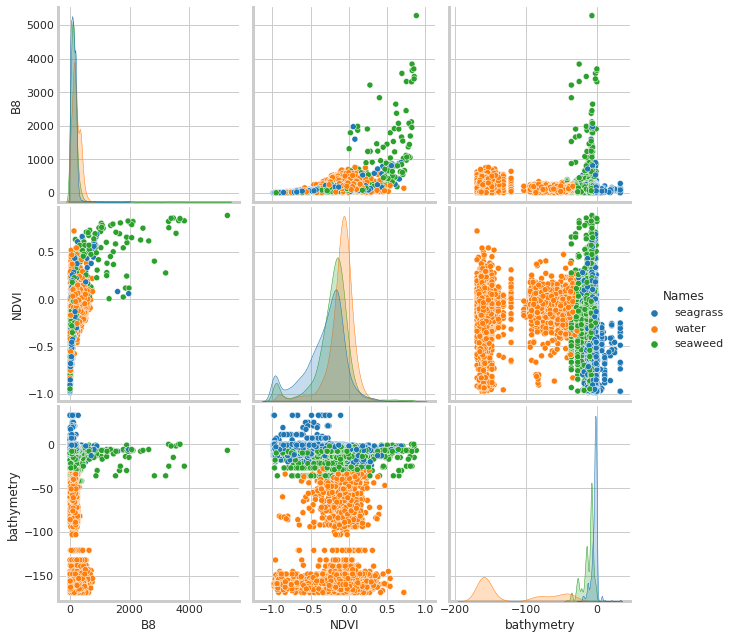

In [ ]:
sns.set_style("whitegrid");
#sns.pairplot(df, hue="Cover", size=3);
sns.pairplot(df_small.iloc[:,[0,1,2,4]], hue="Names", palette="tab10",height=2, size=3)	
sns.set_context(font_scale=1)
plt.show()

In [ ]:
# Based on the grid_search above we choose the best parameters to 
# display predicted training values with in geemap

best_bootstrap = True
best_max_depth= 10              # pruning
best_max_features= None
best_min_samples_leaf = 2
best_min_samples_split = 2
best_n_estimators = 10        # number of trees 

rf = ensemble.RandomForestClassifier(n_estimators=best_n_estimators,
                                     max_depth=best_max_depth,
                                     min_samples_split=best_min_samples_split,
                                     min_samples_leaf=best_min_samples_leaf,
                                     max_features=best_max_features,
                                     bootstrap=best_bootstrap,
                                     n_jobs=-1,
                                     random_state=3).fit(X_train, y_train)

trees = ml.rf_to_strings(rf, feature_names)
# print the first tree to see the result
#print(trees[0])

# number of trees we converted should equal the number of trees we defined for the model
len(trees) == best_n_estimators

# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

# classify the image using the classifier we created from the local training
# note: here we select the feature_names from the image that way the classifier knows which bands to use
#trail1 = [] 

classified = S2_deglint.select(feature_names).classify(ee_classifier)
type(classified)

ee.image.Image

In [ ]:
Map.addLayer(
    classified,
    {"min": 0, "max": 4, "palette": [ 'red','blue' ,'orange','green' ,'yellow']},   #  ['#7b3e00', '#0d98ba', '1c5f2c', ]
    'classification')

# Import land-mask
visParams = {'bands': ['B4', 'B3', 'B2'], max: 0.3}

# Load or import the Hansen et al. forest change dataset.
hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')

# Select the land/water mask.
datamask = hansenImage.select('datamask')

#Create a binary mask.
mask = datamask.eq(1)

# Update the composite mask with the water mask.
maskedComposite = image.updateMask(mask)
Map.addLayer(maskedComposite, visParams, 'masked')

vis_params_sw = {'color':'#7b3e00'}
vis_params_sg = {'color':'1c5f2c'} 
vis_params_water = {'color':'#0d98ba'}  

Map.addLayer(seagrass_shp, vis_params_sg, 'seagrass')
Map.addLayer(seaweed_shp, vis_params_sw, 'seaweed')
Map.addLayer(water_shp, vis_params_water, 'water')

Map

Map(bottom=48075.33334350586, center=[43.77241600463571, -69.63307359268029], controls=(WidgetControl(options=…

In [ ]:
# Define a legend dictionary:

legend_dict = {
    '(2) seaweed': '7b3e00', # brown
    '(1) seagrass': '1c5f2c', # green
    '(0) water': '466b9f' # blue
}

Map.add_legend(title= 'Seagrass and seaweed cover classification', legend_dict = legend_dict)
Map.addLayerControl()

Map

Map(bottom=48075.0, center=[43.77241600463571, -69.63307359268029], controls=(WidgetControl(options=['position…

In [ ]:
labels, counts = np.unique(y_train, return_counts=True)
print(labels)
print(counts)

[1 2 3]
[4005 3965 3940]


In [ ]:
# predict on X_test to evaluate the model
preds = rf.predict(X_valid)
cm = confusion_matrix(y_valid, preds, labels=labels)

In [ ]:
len(y_valid)


1489

In [ ]:
type(feature_names)

list

In [ ]:
type(preds)

numpy.ndarray

In [ ]:
classes = np.array(['water','seaweed','seagrass'])
print(classes)
type(classes)

class_dict = dict(zip(classes,range(len(classes))))

class_dict

['water' 'seaweed' 'seagrass']


{'water': 0, 'seaweed': 1, 'seagrass': 2}

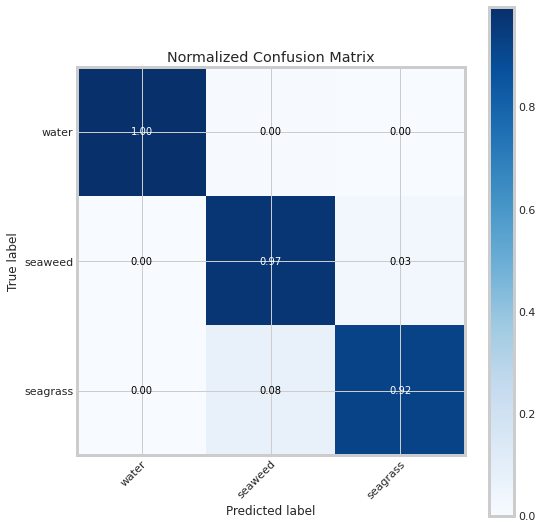

In [ ]:
# plot the confusion matrix
%matplotlib inline 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Because we have a single column. We are summing across a column --> We get out an arrray 
fig, ax = plt.subplots(figsize=(8, 8))  # create firgure 
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # cmap = colormap
ax.figure.colorbar(im, ax=ax)

## Format confusion matrix.
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [ ]:
# Overall accuracy for pixel-based RF on the validation set

accuracy_score(preds, y_valid)

0.9623908663532572